# Part One

Todays problem is quite simple to model, but it may be harder to solve without a human watching the output. I'm going to start with a simple model, outputting the star positions after a certain number of seconds; I will then try and make a nice animation which can be paused at the right moment; finally, I may try to find a heuristic to recognize when the message has been found. Once I know a bit more about the letters, I may even try to extract the message with code. 

In [1]:
import re
import numpy as np

def get_points(lines):
    pat = re.compile(r"position=<(-? ?\d*), (-? ?\d*)> velocity=<(-? ?\d*), (-? ?\d*)>")
    points, velocities = [], []
    for l in lines:
        match = [int(n) for n in pat.match(l).groups()]
        points.append(match[:2])
        velocities.append(match[2:])
    points, velocities = np.array(points), np.array(velocities)
    return points, velocities


In [2]:
def read_input(filename):
    with open(filename) as inp:
        return get_points(inp.readlines())

In [3]:
p, v = read_input("input.txt")

Okay, so after talking with my father, he suggested how to find the time until the points come together. All the points are moving towards their final destinations. Looking only at the y axis, at the point they are in formation all the points on one row will intersect on the y axis. If we can find two points which will be on the same row, we can calculate the time until they intersect with a little simple linear algebra:

$$t \times dy + y1 = t \times (-dy) + y2$$
$$t = \frac{y2 - y1}{2dy}$$

Now the problem is simply to find two points which will end up on the same row, or at least very near it. 

In [4]:
print('Maximum and minimum vertical velocities are respectively {} and {}'.format(v.T[1].max(), v.T[1].min()))

Maximum and minimum vertical velocities are respectively 5 and -5


In [5]:
dy = v.T[1].max()
y1 = p[v.T[1] ==  dy].T[1].min()
y2 = p[v.T[1] == -dy].T[1].min()

time_til_intersect = (y2 - y1)/(2*dy)

In [6]:
moved_points = p + time_til_intersect * v

In [7]:
size = (int(moved_points.T[1].ptp()) + 1, int(moved_points.T[0].ptp()) + 1)
shift = moved_points.T.min(1)

In [8]:
im = np.full(size, 255, dtype=np.ubyte)
for point in moved_points:
    im[int((point-shift)[1]), int((point-shift)[0])] = 0

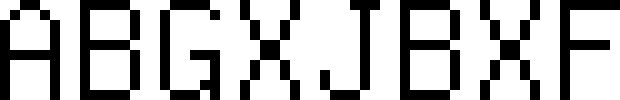

In [9]:
from PIL import Image

render = Image.fromarray(im, 'L')
render.resize([d*10 for d in size[::-1]])

# Part Two

In [10]:
print(time_til_intersect)

10619.0


# Animation

In [11]:
from matplotlib import pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import math

fig, ax = plt.subplots()
_ = ax.axis('auto')
_ = ax.set_aspect(0.8)
l, = ax.plot(*(p*time_til_intersect*(2/3)).T, 'b', linestyle='None', marker='s')
NFRAMES = 33

def animate(i):
    l.set_data(*(p+v*i).T*np.array([[1],[-1]]))
    ax.relim()
    ax.autoscale_view()
    
def generate_frames():
    for t in range(NFRAMES):
        t = t / (NFRAMES - 1)
        t -= 1
        yield (time_til_intersect*(1/3)) * (t**5 + 1) + (time_til_intersect*(2/3))


ani = matplotlib.animation.FuncAnimation(fig, animate, frames=generate_frames)

HTML(ani.to_jshtml())